In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import numpy as np
import os
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date

import scipy 
from scipy import optimize
import scipy.signal as signal 
import sys

    
sys.path.append('../../dsmuc/')
from dsmuc.custom import detect_peaks
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs


import pytz
from azure.storage.blob import BlockBlobService
from io import StringIO
from azure.storage.blob import AppendBlobService
from azure.storage.blob import BlockBlobService
import requests
import json




import keras
from keras import backend as K
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten, Reshape, BatchNormalization
from keras.layers import LSTM,GRU
from keras.preprocessing import sequence
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Conv2D, AveragePooling1D, MaxPooling2D
from keras.models import Model

label_dict = {1:'walking',
             2:'walking upstairs',
             3:'walking downstairs',
             4:'sitting',
             5:'standing',
             6:'laying',
             7:'unknown'}
n_classes = 6
def CNN1(timesteps):
    # 77% accuracy
    model = Sequential()
    model.add(Conv1D(8,
                    64,
                     input_shape=(600,1),
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(16,
                    16,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(64,
                    8,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(128,
                    4,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Conv1D(256,
                    2,
                     padding='valid',
                     strides=1))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size = 2))
    model.add(Flatten())
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    
    return model
# download_dir =  "../../data/G9_data/Downloaded"


# Model saved
# filename = 'finalized_model.sav'
# logreg = pickle.load(open(filename, 'rb'), encoding = 'iso-8859-1')
model = CNN1(600)
model.load_weights('weights.hdf5')

/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 537, 8)            520       
_________________________________________________________________
batch_normalization_1 (Batch (None, 537, 8)            32        
_________________________________________________________________
activation_1 (Activation)    (None, 537, 8)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 268, 8)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 253, 16)           2064      
_________________________________________________________________
batch_normalization_2 (Batch (None, 253, 16)           64        
_________________________________________________________________
activation_2 (Activation)    (None, 253, 16)           0         
__________

In [12]:
graph = tf.get_default_graph()

In [2]:
import pdb

In [3]:
def time_to_str(t):
    t_woM = t.replace(microsecond=0)
    dt64 = np.datetime64(t_woM)
    a = dt64.astype('datetime64[s]')
    
    return np.datetime_as_string(a)+"Z"
def f(x):
    u, c = np.unique(x['predictions'].values, return_counts=True)
    outcome = u[np.argmax(c)]
    return outcome

In [4]:
##################
#### READ DATA ###
##################
day_now=0
day_before=1

account_name='watchstorage'
account_key='TJWcjsCs4aK9Xorw4DIAZGvKz0AFb2kvgSh49t+3nADR2usZ1ED14GLBQ/klJsSSrKykxu0ghCXn46+0bv2J8Q=='
container_name_ = 'jnj'

blob_service = BlockBlobService(account_name=account_name, account_key = account_key)


blobs = [];blob_date = []
generator = blob_service.list_blobs(container_name_)
for blob in generator:
    blobs.append(blob.name)
    blob_date.append(blob.name[:10])
# Create Datafrrame consists of all folders in jnj folder
blob_table_all = pd.DataFrame()
blob_table_all['date'] = blob_date
blob_table_all['blobname'] = blobs 
blob_table_all.set_index('date',inplace=True)
today = date.today().strftime('%Y-%m-%d')
yesterday = (date.today() - timedelta(1)).strftime('%Y-%m-%d')




In [5]:
blob_table_all.tail()

,blobname
date,
2018-07-28,2018-07-28/873240569_9bd0f9d6062248eca26d46a44...
2018-07-29,2018-07-29/873240569_615e8e56fdd548be919dfe20a...
2018-07-30,2018-07-30/873240569_6e18893d37774c7b935e8e043...
2018-07-31,2018-07-31/873240569_7365b249ca0f4c1e9db28263a...
2018-08-01,2018-08-01/873240569_9474bbac441b4edc8afc60d02...


In [33]:
dates = [ '2018-08-01']
blob_table = pd.DataFrame()
file_names = []
for date in dates:
     file_names.append(blob_table_all.loc[date]['blobname'])
blob_df = pd.DataFrame()
# blobname is the csv
for fn in file_names:
    blob_Class = blob_service.get_blob_to_text(container_name=container_name_, blob_name = fn)
    blob_String =blob_Class.content

    for chunk in pd.read_csv(StringIO(blob_String), chunksize=10000):
        blob_df = blob_df.append(chunk)

print("READ DATA FRAMES SIZE :",blob_df.shape[0])


AzureHttpError: The condition specified using HTTP conditional header(s) is not met.
<?xml version="1.0" encoding="utf-8"?><Error><Code>ConditionNotMet</Code><Message>The condition specified using HTTP conditional header(s) is not met.
RequestId:ae348fd4-601e-000e-5c9c-2977e6000000
Time:2018-08-01T13:34:32.6597384Z</Message></Error>

In [8]:
blob_df['id'].unique()[::-1]

array(['watch-sensor-356969030413245'], dtype=object)

In [9]:
start_day_for_prediction = '2018-07-30'
end_day_for_prediction = '2018-07-31'

Watch  watch-sensor-356969030413245  is being processed
Extracting interested sensor data...
READ DATA FRAMES SIZE AFTER CLEANING : 329458
doing time: 2018-07-30 00:00:00  -  2018-07-30 00:05:00
doing time: 2018-07-30 00:05:00  -  2018-07-30 00:10:00
doing time: 2018-07-30 00:10:00  -  2018-07-30 00:15:00
doing time: 2018-07-30 00:15:00  -  2018-07-30 00:20:00
doing time: 2018-07-30 00:20:00  -  2018-07-30 00:25:00
doing time: 2018-07-30 00:25:00  -  2018-07-30 00:30:00
doing time: 2018-07-30 00:30:00  -  2018-07-30 00:35:00
doing time: 2018-07-30 00:35:00  -  2018-07-30 00:40:00
doing time: 2018-07-30 00:40:00  -  2018-07-30 00:45:00
doing time: 2018-07-30 00:45:00  -  2018-07-30 00:50:00
doing time: 2018-07-30 00:50:00  -  2018-07-30 00:55:00
doing time: 2018-07-30 00:55:00  -  2018-07-30 01:00:00


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  del sys.path[0]
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()


doing time: 2018-07-30 01:00:00  -  2018-07-30 01:05:00
doing time: 2018-07-30 01:05:00  -  2018-07-30 01:10:00
doing time: 2018-07-30 01:10:00  -  2018-07-30 01:15:00
doing time: 2018-07-30 01:15:00  -  2018-07-30 01:20:00
doing time: 2018-07-30 01:20:00  -  2018-07-30 01:25:00
doing time: 2018-07-30 01:25:00  -  2018-07-30 01:30:00
doing time: 2018-07-30 01:30:00  -  2018-07-30 01:35:00
doing time: 2018-07-30 01:35:00  -  2018-07-30 01:40:00
doing time: 2018-07-30 01:40:00  -  2018-07-30 01:45:00
doing time: 2018-07-30 01:45:00  -  2018-07-30 01:50:00
doing time: 2018-07-30 01:50:00  -  2018-07-30 01:55:00
doing time: 2018-07-30 01:55:00  -  2018-07-30 02:00:00
doing time: 2018-07-30 02:00:00  -  2018-07-30 02:05:00
doing time: 2018-07-30 02:05:00  -  2018-07-30 02:10:00
doing time: 2018-07-30 02:10:00  -  2018-07-30 02:15:00
doing time: 2018-07-30 02:15:00  -  2018-07-30 02:20:00
doing time: 2018-07-30 02:20:00  -  2018-07-30 02:25:00
doing time: 2018-07-30 02:25:00  -  2018-07-30 0

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:62: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


doing time: 2018-07-30 07:55:00  -  2018-07-30 08:00:00
doing time: 2018-07-30 08:00:00  -  2018-07-30 08:05:00
doing time: 2018-07-30 08:05:00  -  2018-07-30 08:10:00
doing time: 2018-07-30 08:10:00  -  2018-07-30 08:15:00
doing time: 2018-07-30 08:15:00  -  2018-07-30 08:20:00
doing time: 2018-07-30 08:20:00  -  2018-07-30 08:25:00
doing time: 2018-07-30 08:25:00  -  2018-07-30 08:30:00
doing time: 2018-07-30 08:30:00  -  2018-07-30 08:35:00
doing time: 2018-07-30 08:35:00  -  2018-07-30 08:40:00
doing time: 2018-07-30 08:40:00  -  2018-07-30 08:45:00
doing time: 2018-07-30 08:45:00  -  2018-07-30 08:50:00
doing time: 2018-07-30 08:50:00  -  2018-07-30 08:55:00
doing time: 2018-07-30 08:55:00  -  2018-07-30 09:00:00
doing time: 2018-07-30 09:00:00  -  2018-07-30 09:05:00
doing time: 2018-07-30 09:05:00  -  2018-07-30 09:10:00
doing time: 2018-07-30 09:10:00  -  2018-07-30 09:15:00
doing time: 2018-07-30 09:15:00  -  2018-07-30 09:20:00
doing time: 2018-07-30 09:20:00  -  2018-07-30 0

doing time: 2018-07-30 20:50:00  -  2018-07-30 20:55:00
doing time: 2018-07-30 20:55:00  -  2018-07-30 21:00:00
doing time: 2018-07-30 21:00:00  -  2018-07-30 21:05:00
doing time: 2018-07-30 21:05:00  -  2018-07-30 21:10:00
doing time: 2018-07-30 21:10:00  -  2018-07-30 21:15:00
doing time: 2018-07-30 21:15:00  -  2018-07-30 21:20:00
doing time: 2018-07-30 21:20:00  -  2018-07-30 21:25:00
doing time: 2018-07-30 21:25:00  -  2018-07-30 21:30:00
doing time: 2018-07-30 21:30:00  -  2018-07-30 21:35:00
doing time: 2018-07-30 21:35:00  -  2018-07-30 21:40:00
doing time: 2018-07-30 21:40:00  -  2018-07-30 21:45:00
doing time: 2018-07-30 21:45:00  -  2018-07-30 21:50:00
doing time: 2018-07-30 21:50:00  -  2018-07-30 21:55:00
doing time: 2018-07-30 21:55:00  -  2018-07-30 22:00:00
doing time: 2018-07-30 22:00:00  -  2018-07-30 22:05:00
doing time: 2018-07-30 22:05:00  -  2018-07-30 22:10:00
doing time: 2018-07-30 22:10:00  -  2018-07-30 22:15:00
doing time: 2018-07-30 22:15:00  -  2018-07-30 2

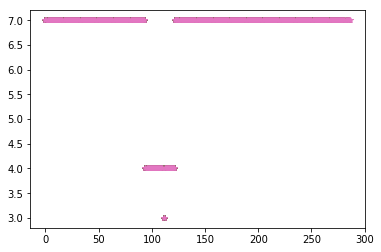

success uploading watch data


In [30]:
columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']


for watch_id in blob_df['id'].unique()[::-1]:
    print("Watch ", watch_id," is being processed" )
    df_temp = io.read_g9(blob_df[blob_df['id']==watch_id], sort=False)
    df_temp = df_temp.sort_index()
    print("READ DATA FRAMES SIZE AFTER CLEANING :",df_temp.shape[0])
    
    
    # Time to do analysis is specified
    start = start_day_for_prediction + 'T00:00:00.0000Z'
    start_temp = np.datetime64(start)
    t = pd.Timestamp(start_temp)
    end = end_day_for_prediction + 'T00:00:00.0000Z'
    end_temp = np.datetime64(end)
    end_time = pd.Timestamp(end_temp)

    # Initialize 
    whole_window_size = timedelta(minutes = 5)
    window_size = timedelta(seconds=2)
    window_slide = timedelta(seconds=1)
    samples_count = []
    a = 0
    df_out = pd.DataFrame()
    t_start_list = []
    t_end_list = []
    outcome_list = []
    while (t + whole_window_size < end_time):
        label_list = []
        increment = 0
        X = []
        t_end5min= t + whole_window_size 
        print("doing time:",t, ' - ', t_end5min)
        t_start_list.append(time_to_str(t))
        t_end_list.append(time_to_str(t_end5min))
        if df_temp.between_time(t.to_pydatetime().time(), t_end5min.to_pydatetime().time()\
                                           ,include_start=True, include_end=False).shape[0] >= 10:


            while(t+window_slide< t_end5min):
                t_end = t + window_size
                snippet_df = df_temp.between_time(t.to_pydatetime().time(), t_end.to_pydatetime().time()
                                               ,include_start=True, include_end=False)
                if snippet_df.shape[0]>= 20:
                    X.append(snippet_df[columns].values)
                t = t_end
        else:
            t = t_end5min

        if len(X)<=2:
            outcome = 7.0
        else:
            X_test = np.array(X)
            X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=100, dtype='float32',
            padding='pre', truncating='pre', value=0.)
            
            
            test_shape = X_test.shape
            X_test = X_test.reshape(test_shape[0], -1,1)
            with graph.as_default():
                y_score = model.predict_proba(X_test)   
            y_pred = np.argmax(pd.rolling_mean(y_score, 50,min_periods=1), axis=1) + 1 # add 1 for correcting index
            u, c = np.unique(y_pred, return_counts=True)
            outcome = u[np.argmax(c)] # Majority vote
            
            
        outcome_list.append(label_dict[int(outcome)])
        out_ser = pd.Series(outcome,name=(t-whole_window_size, t) )
        df_out = df_out.append(out_ser)
        plt.plot(list(range(df_out.shape[0])), df_out[0], "*")
    
    plt.show()   
    
    # Create the json string to upload 
    dict_list = []
    for i in range(len(outcome_list)):
        payload_dict = {'address':watch_id.split("-")[2],
             'starttime':t_start_list[i],
             'endtime':t_end_list[i],
             'tasklocation':'Activity',
             'taskname':outcome_list[i],
             'name':outcome_list[i],
             'value':1}
        dict_list.append(payload_dict)
    payload = json.dumps(dict_list)
    url = "https://colife-dashboard.silverline.mobi/uploadActivityLabelForSmartWatch"
    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "87b2b04f-175f-4a9b-f2c8-bf31de2cae7d"
        }
    # Send the data 
    response = requests.request("POST", url, data=payload, headers=headers)
    print(response.text)

